# Introduction to pyTigerGraph
## TigerGraph ML Team

pyTigerGraph is the Python API for [TigerGraph](https://www.tigergraph.com/). It can be used to query and update data in a TigerGraph database. Full documentation is available [here](https://github.com/pyTigerGraph/pyTigerGraph).

## Creating a Connection
Here, we will create a connection to a TigerGraph database. There are many different parameters that can be used to connect based upon the specific instance, but we will use the defaults, and therefore only need to specify the host.

In [1]:
import pyTigerGraph as tg
import pandas as pd

conn = tg.TigerGraphConnection("https://parker-fraud.i.tgcloud.io")

## Verifying the Connection
We will print out the result of a GSQL `LS` command to verify that we are connected to the database.

In [2]:
print(conn.gsql("LS"))

---- Graph MyGraph
Vertex Types:
- VERTEX email(PRIMARY_ID id STRING, address STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX bank(PRIMARY_ID id STRING, name STRING, ABA_routing_number UINT, swift_code UINT) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX device(PRIMARY_ID id STRING, manufacturer STRING, model STRING, IMEI STRING, trust_score FLOAT DEFAULT "0.5") WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX payment(PRIMARY_ID id STRING, amount FLOAT, transaction_date STRING, transactionEpoch UINT, trust_score FLOAT) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX phone_number(PRIMARY_ID id STRING, number STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX merchant_account(PRIMARY_ID id STRING, create_date STRING, createEpoch UINT, phone_number STRING, email STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="fal

## Add a API token to the Connection
We will add an API token to the connection to allow us to query and update data via the REST++ interface.

In [3]:
conn.apiToken = conn.getToken(conn.createSecret())

## Vertex Statistics
Here, we get some statistics about the vertices in the database.

In [4]:
conn.getVertexStats(conn.getVertexTypes())

{'email': {},
 'bank': {'ABA_routing_number': {'MAX': 0, 'MIN': 0, 'AVG': 0},
  'swift_code': {'MAX': 0, 'MIN': 0, 'AVG': 0}},
 'device': {'trust_score': {'MAX': 0.5, 'MIN': 0, 'AVG': 0.48993}},
 'payment': {'amount': {'MAX': 791, 'MIN': 40, 'AVG': 418.04412},
  'transactionEpoch': {'MAX': 1562976000,
   'MIN': 952646400,
   'AVG': 1273106541.1617646},
  'trust_score': {'MAX': 0.5, 'MIN': 0, 'AVG': 0.49632}},
 'phone_number': {},
 'merchant_account': {'createEpoch': {'MAX': 1562976000,
   'MIN': 0,
   'AVG': 1062250740}},
 'user_account': {'createEpoch': {'MAX': 1562976000,
   'MIN': 0,
   'AVG': 1079826700.5780346},
  'trust_score': {'MAX': 0.5, 'MIN': 0, 'AVG': 0.49422}},
 'user': {'trust_score': {'MAX': 0.5, 'MIN': 0, 'AVG': 0.49333},
  'createEpoch': {'MAX': 1562976000, 'MIN': 0, 'AVG': 1254104064}}}

## Time vs. Trust Score

In [5]:
user_account_df = pd.DataFrame(conn.getVertices("user_account"))

In [6]:
user_account_df.head()

,v_id,v_type,attributes
0,user_account43,user_account,"{'created_date': '11/9/04', 'createEpoch': 109..."
1,user_account134,user_account,"{'created_date': '9/13/01', 'createEpoch': 100..."
2,user_account5,user_account,"{'created_date': '1/6/11', 'createEpoch': 1294..."
3,user_account116,user_account,"{'created_date': '2/27/14', 'createEpoch': 139..."
4,user_account155,user_account,"{'created_date': '3/13/06', 'createEpoch': 114..."


In [7]:
user_account_df = pd.concat([user_account_df.drop(['attributes'], axis=1), user_account_df['attributes'].apply(pd.Series)], axis=1)

In [8]:
user_account_df.head()

,v_id,v_type,created_date,createEpoch,trust_score
0,user_account43,user_account,11/9/04,1099958400,0.5
1,user_account134,user_account,9/13/01,1000339200,0.5
2,user_account5,user_account,1/6/11,1294272000,0.5
3,user_account116,user_account,2/27/14,1393459200,0.5
4,user_account155,user_account,3/13/06,1142208000,0.5


In [9]:
user_account_df.shape

(173, 5)

<AxesSubplot:xlabel='createEpoch', ylabel='trust_score'>

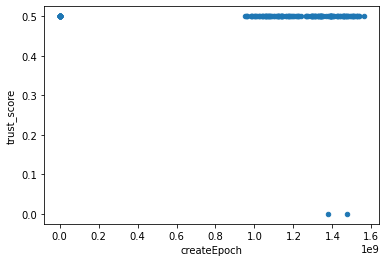

In [10]:
user_account_df[["trust_score", "createEpoch"]].plot(x="createEpoch", y="trust_score", kind="scatter")

In [11]:
payment_df = pd.DataFrame(conn.getVertices("payment"))

In [13]:
payment_df = pd.concat([payment_df.drop(['attributes'], axis=1), payment_df['attributes'].apply(pd.Series)], axis=1)

In [14]:
payment_df.head()

,v_id,v_type,amount,transaction_date,transactionEpoch,trust_score
0,payment152,payment,308,4/13/13,1365811200,0.5
1,payment65,payment,701,3/22/15,1426982400,0.5
2,payment113,payment,49,2/12/14,1392163200,0.5
3,payment79,payment,419,2/9/10,1265673600,0.5
4,payment89,payment,487,5/8/00,957744000,0.5


<AxesSubplot:xlabel='transactionEpoch', ylabel='trust_score'>

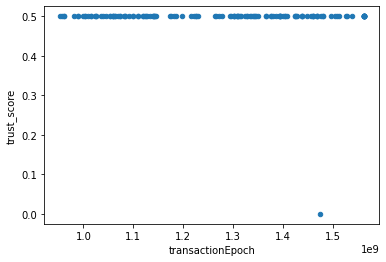

In [16]:
payment_df[["trust_score", "transactionEpoch"]].plot(x="transactionEpoch", y="trust_score", kind="scatter")

## Transaction Amount vs. Trust Score

<AxesSubplot:xlabel='amount', ylabel='trust_score'>

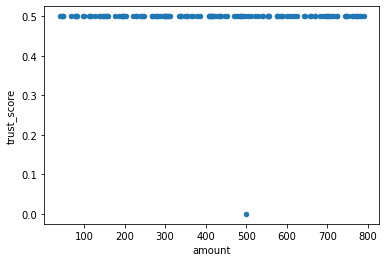

In [17]:
payment_df[["trust_score", "amount"]].plot(x="amount", y="trust_score", kind="scatter")

## PageRank

In [47]:
pr = '''
DROP QUERY tg_pagerank
CREATE QUERY tg_pagerank (SET<STRING> v_type, SET<STRING> e_type,
 FLOAT max_change=0.001, INT max_iter=25, FLOAT damping=0.85, INT top_k = 100,
 BOOL print_accum = TRUE, STRING result_attr =  "", STRING file_path = "",
 BOOL display_edges = FALSE) {
/*
 Compute the pageRank score for each vertex in the GRAPH
 In each iteration, compute a score for each vertex:
     score = (1-damping) + damping*sum(received scores FROM its neighbors).
 The pageRank algorithm stops when either of the following is true:
 a) it reaches max_iter iterations;
 b) the max score change for any vertex compared to the last iteration <= max_change.
 v_type: vertex types to traverse          print_accum: print JSON output
 e_type: edge types to traverse            result_attr: INT attr to store results to
 max_iter; max #iterations                 file_path: file to write CSV output to
 top_k: #top scores to output              display_edges: output edges for visualization
 max_change: max allowed change between iterations to achieve convergence
 damping: importance of traversal vs. random teleport

 This query supports only taking in a single edge for the time being (8/13/2020).
*/
TYPEDEF TUPLE<VERTEX Vertex_ID, FLOAT score, FLOAT trust_score> Vertex_Score;
HeapAccum<Vertex_Score>(top_k, score DESC) @@top_scores_heap;
MaxAccum<FLOAT> @@max_diff = 9999;    # max score change in an iteration
SumAccum<FLOAT> @sum_recvd_score = 0; # sum of scores each vertex receives FROM neighbors
SumAccum<FLOAT> @sum_score = 1;           # initial score for every vertex is 1.
SetAccum<EDGE> @@edge_set;             # list of all edges, if display is needed
FILE f (file_path);

# PageRank iterations	
Start = {v_type};                     # Start with all vertices of specified type(s)
WHILE @@max_diff > max_change 
    LIMIT max_iter DO
        @@max_diff = 0;
    V = SELECT s
	FROM Start:s -(e_type:e)-> v_type:t
	ACCUM 
            t.@sum_recvd_score += s.@sum_score/(s.outdegree(e_type)) 
	POST-ACCUM 
            s.@sum_score = (1.0-damping) + damping * s.@sum_recvd_score,
	    s.@sum_recvd_score = 0,
	    @@max_diff += abs(s.@sum_score - s.@sum_score');
END; # END WHILE loop

# Output
IF file_path != "" THEN
    f.println("Vertex_ID", "PageRank");
END;
V = SELECT s 
    FROM Start:s
    POST-ACCUM 
        IF result_attr != "" THEN 
            s.setAttr(result_attr, s.@sum_score) 
        END,
   
	IF file_path != "" THEN 
            f.println(s, s.@sum_score) 
        END,
   
	IF print_accum THEN 
            @@top_scores_heap += Vertex_Score(s, s.@sum_score, s.trust_score) 
        END;

IF print_accum THEN
    PRINT @@top_scores_heap;
    IF display_edges THEN
        PRINT Start[Start.@sum_score];
	Start = SELECT s
	        FROM Start:s -(e_type:e)-> v_type:t
	        ACCUM @@edge_set += e;
        PRINT @@edge_set;
    END;
END;
}

INSTALL QUERY tg_pagerank
'''

In [48]:
print(conn.gsql(pr))

Successfully dropped queries on the graph 'MyGraph': [tg_pagerank].
Successfully created queries: [tg_pagerank].
Start installing queries, about 1 minute ...
tg_pagerank query: curl -X GET 'https://127.0.0.1:9000/query/MyGraph/tg_pagerank?v_type=VALUE&e_type=VALUE&[max_change=VALUE]&[max_iter=VALUE]&[damping=VALUE]&[top_k=VALUE]&[print_accum=VALUE]&[result_attr=VALUE]&[file_path=VALUE]&[display_edges=VALUE]'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.
Select 'm1' as compile server, now connecting ...
Node 'm1' is prepared as compile server.

Query installation finished.


In [24]:
def createParamString(vertexTypes, edgeTypes, params):
    paramUrl = ""
    for vType in vertexTypes:
        paramUrl += ("v_type="+vType+"&")
    for eType in edgeTypes:
        paramUrl += ("e_type="+eType+"&")
    for p in params.keys():
        paramUrl += (p+"="+str(params[p])+"&")
    paramUrl = paramUrl[:-1]
    return paramUrl

In [51]:
params = {
    "top_k":1500,
}

res = conn.runInstalledQuery("tg_pagerank", params=createParamString(conn.getVertexTypes(), conn.getEdgeTypes(), params))[0]["@@top_scores_heap"]

In [52]:
df = pd.DataFrame(res)

In [53]:
df.head()

,Vertex_ID,score,trust_score
0,user_account40,3.89393,0.5
1,user_account76,1.54076,0.5
2,user_account74,1.54076,0.5
3,user_account54,1.49470,0.5
4,user_account72,1.49470,0.5


<AxesSubplot:xlabel='score', ylabel='trust_score'>

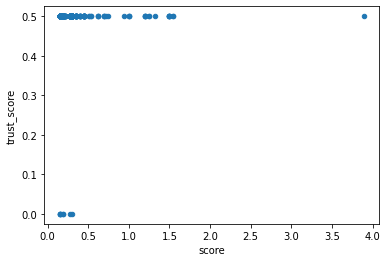

In [54]:
df[["trust_score", "score"]].plot(x="score", y="trust_score", kind="scatter")

In [55]:
df[df["trust_score"] < 0.1].describe()

,score,trust_score
count,8.000000,8.0
mean,0.194758,0.0
std,0.059798,0.0
min,0.150000,0.0
25%,0.150000,0.0
50%,0.171250,0.0
75%,0.213750,0.0
max,0.295560,0.0


In [57]:
df[df["trust_score"] > 0.1].describe()

,score,trust_score
count,600.000000,600.0
mean,0.251737,0.5
std,0.256551,0.0
min,0.150000,0.5
25%,0.150000,0.5
50%,0.192500,0.5
75%,0.295560,0.5
max,3.893930,0.5
